# Statistical Modeling II

In [51]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import spearmanr, pearsonr

#!pip install statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
 
import matplotlib.pyplot as plt
import seaborn as sns

## Correlation analysis

Yesterday, we focused on **describing single variables** in the red wine quality dataset. We examined their means, spreads, and distributions. In other words, we summarized each variable on its own by performing **univariate analysis**.

However, in most real-world datasets, variables do not exist in isolation. They often **change together**. For example, as one measurement increases, another may also tend to increase or decrease. The next logical step is therefore to explore **relationships between variables**.

This brings us to two important concepts:

- **Covariance**, which measures how two variables vary together  
- **Correlation**, which standardizes this relationship on a scale from −1 to +1  

Before we look at the mathematical definitions and formulas, we will start with a **visual approach**.

In the Exploratory Data Analysis lecture, I introduced the **Palmer Penguins** dataset and used it to demonstrate different visualization techniques. Here, we will use the same dataset and first replicate those visualizations. In particular, we will create **scatter plots** to examine how pairs of continuous variables relate to each other.

For example, we can ask:
- Do penguins with longer flippers tend to be heavier?
- Do longer bills tend to be associated with smaller bill depth?

#### <font color="#fc7202">Task 1: Visualization of the Palmer Penguins dataset (bivariate analysis)</font>

To explore these questions and create the required visualizations, we first need to **load the dataset**.


In [4]:
penguins = sns.load_dataset('penguins')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


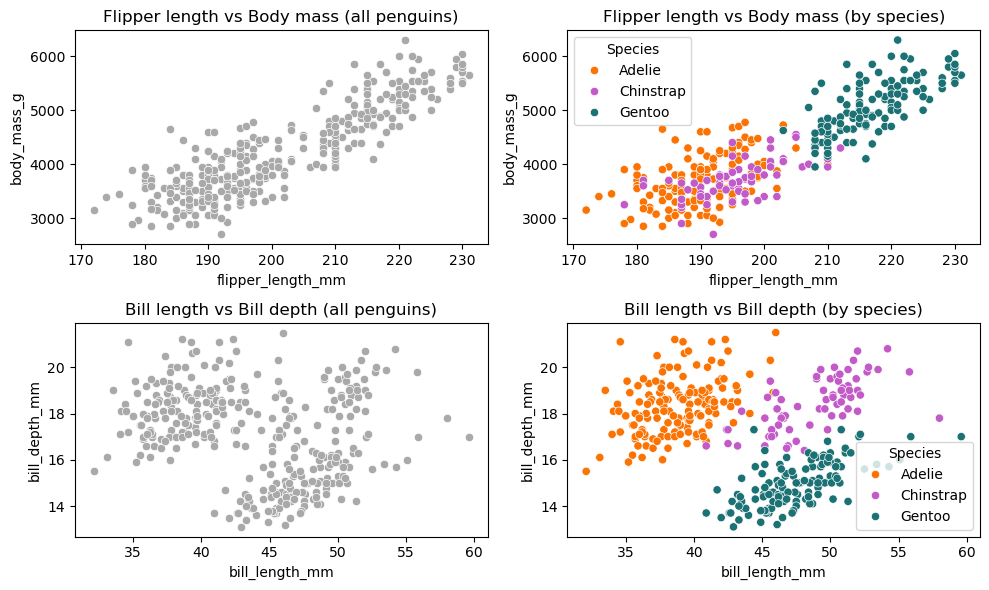

In [11]:
custom_palette = {'Gentoo': '#1b7173', 'Adelie': '#fb7302', 'Chinstrap': '#c25bc7'}

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Flipper length vs body mass
sns.scatterplot(data=penguins, x='flipper_length_mm', y='body_mass_g', color='darkgray', ax=axes[0, 0])
axes[0, 0].set_title('Flipper length vs Body mass (all penguins)')

sns.scatterplot(data=penguins, x='flipper_length_mm', y='body_mass_g',
                hue='species', palette=custom_palette, ax=axes[0, 1])
axes[0, 1].set_title('Flipper length vs Body mass (by species)')
axes[0, 1].legend(title='Species')

# Bill length vs bill depth
sns.scatterplot(data=penguins, x='bill_length_mm', y='bill_depth_mm', color='darkgray', ax=axes[1, 0])
axes[1, 0].set_title('Bill length vs Bill depth (all penguins)')

sns.scatterplot(data=penguins, x='bill_length_mm', y='bill_depth_mm',
                hue='species', palette=custom_palette, ax=axes[1, 1])
axes[1, 1].set_title('Bill length vs Bill depth (by species)')
axes[1, 1].legend(title='Species')

plt.tight_layout()
plt.show()

> The scatter plots above give a first visual impression of how closely two numeric variables are related.
>
> In the top row, we see the relationship between *flipper length* and *body mass*.
> - When looking at all penguins together (left plot), there is a clear upward trend: penguins with longer flippers tend to be heavier.
> - When we color the points by species (right plot), this positive pattern becomes even clearer within each group. Gentoo penguins are generally both larger and heavier, while Adelie and Chinstrap penguins cluster at smaller body sizes.
>
> In the bottom row, the plots show *bill length* versus *bill depth*.
> - Across all penguins (left plot), the points form a scattered, somewhat downward pattern.
> - When colored by species (right plot), distinct clusters appear. Gentoo penguins have longer but shallower bills, Chinstraps tend to have long and relatively deep bills, while Adelies have shorter and deeper bills. When combined, these species differences create an overall negative relationship between bill length and bill depth.
>
> <img src='https://lauranavarroviz.wordpress.com/wp-content/uploads/2020/08/penguinsbill_plot_final.png?w=2034' alt='palmer_penguins' width='500'/>
>
> These examples highlight two key aspects of relationships between variables:
> - Strength - how closely the data points follow a consistent pattern or trend
> - Direction - the orientation of the trend, indicating whether it is positive (upward) or negative (downward)
> Scatter plots provide an intuitive first look at these relationships. In the next step, we will learn how to describe them numerically using covariance and correlation.
>
> But before we do that, it is worth checking out what the `pairplot()` function from `seaborn` can do.

> *Reminder:* `pairplot()` is a convenient way to display all pairwise relationships between numeric variables in one figure.\
> It automatically creates a grid of scatter plots for each variable pair and shows the distribution of each variable along the diagonal.

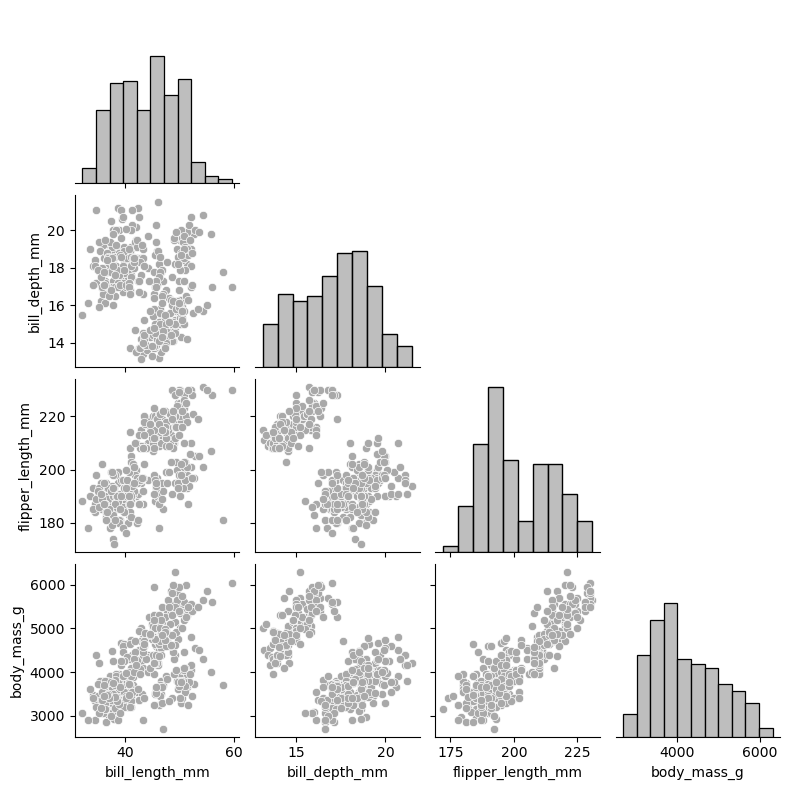

In [13]:
sns.pairplot(penguins, vars=['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], 
             corner=True, height=2, aspect=1, plot_kws={'color': 'darkgray'}, diag_kws={'color': 'darkgray'} )
plt.show()

> By default, `pairplot()` creates a full matrix of plots - meaning it repeats the same scatter plots above and below the diagonal.\
> Setting `corner=True` tells seaborn to show only the lower triangle of this grid, removing duplicate plots and making the figure cleaner and easier to read.
>
> We can also color the points by species to reveal how group differences shape these relationships:

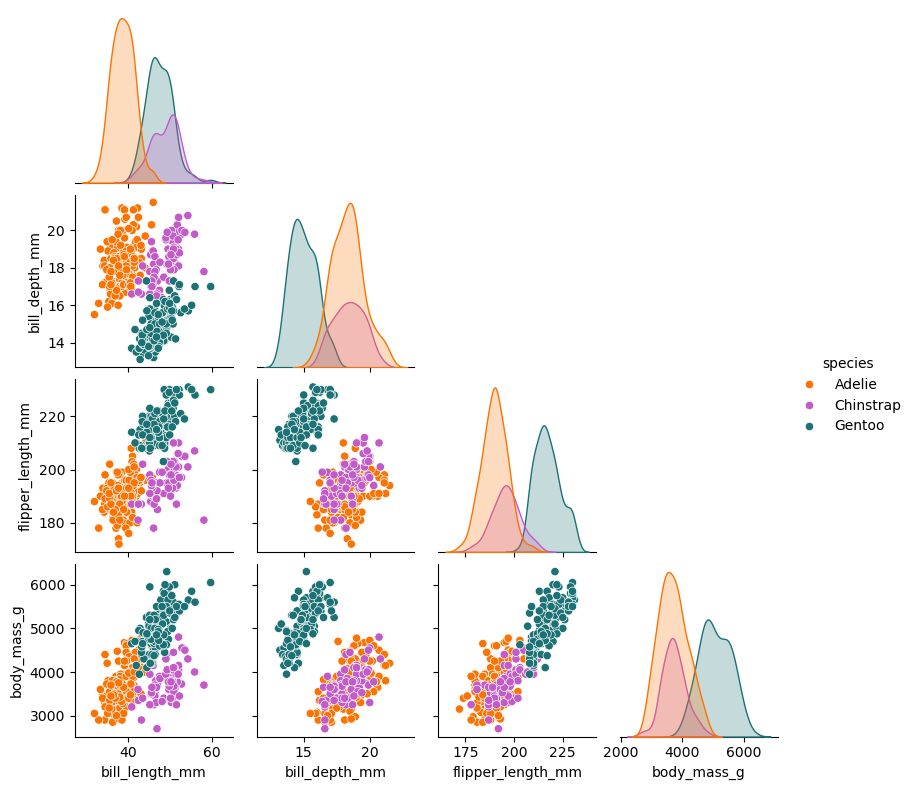

In [14]:
sns.pairplot(penguins, vars=['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], hue='species',
             palette={'Gentoo': '#1b7173', 'Adelie': '#fb7302', 'Chinstrap': '#c25bc7'}, corner=True, height=2, aspect=1)
plt.show()

> This gives an excellent overview of the dataset:
> - The diagonal shows the distribution of each numeric variable.
> - The lower triangle displays pairwise scatter plots, highlighting the direction and strength of associations.
> - Coloring by species makes it clear how inter-species differences contribute to the overall relationships.
>
> In short, `pairplot()` is a powerful first step for visual data exploration, allowing us to observe relationships across all variables before quantifying them with covariance or correlation.

#### Correlation coefficient  

So far, our scatter plots have shown visually whether two variables *move together* and in which direction.  
To make this idea more precise, we can describe the **strength** and **direction** of a relationship with a single number: the **correlation coefficient**.

The most common version is **Pearson’s correlation coefficient** (Pearson product moment correlation coefficient), usually denoted as $r$.  
It measures the **linear association** between two continuous variables and always takes a value between −1 and +1:

- $r = +1$ → perfect positive linear relationship  
- $r = 0$ → no linear relationship  
- $r = −1$ → perfect negative linear relationship  

Values close to +1 or −1 indicate strong linear associations, while values near 0 indicate weak or no linear relationship.

---

**Covariance: the idea behind correlation**

To understand correlation, it helps to first look at **covariance**.  
Covariance is a generalization of variance that measures how two variables vary together:

$$
\mathrm{Cov}(X, Y) = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})
$$

If both variables tend to move in the same direction, meaning both increase or both decrease together, the covariance is **positive**.  
If one variable tends to increase when the other decreases, the covariance is **negative**.  
If the variables are unrelated, the covariance is approximately **zero**.

However, covariance is expressed in the **combined units** of both variables, for example millimeters × grams, which makes it difficult to interpret and compare.

---

**Standardizing the covariance**

Pearson’s correlation addresses this issue by **standardizing** the covariance, dividing it by the standard deviations of both variables:

$$
r = \frac{\mathrm{Cov}(X, Y)}{s_X \, s_Y}
$$

$$
\boxed{
r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2 \sum_{i=1}^{n}(y_i - \bar{y})^2}}
}
$$

This removes the units and constrains the result to the range from −1 to +1.  
The resulting value of $r$ preserves the sign of the covariance but now has a **meaningful and comparable scale**.

---
**Interpreting correlation values**\
Naturally, in real data you rarely see correlations of exactly +1 or −1. So how should we interpret a correlation of, say, 0.4 or 0.7?
The answer depends on both the context and the discipline.

For example:
- In engineering, correlations below 0.9 might be considered weak
- In psychology or environmental sciences, correlations around 0.5 are already considered meaningful.
- In many biological or social datasets, even smaller correlations can be important if they are consistent and statistically significant.

In short, interpretation depends on what the data represent and how strong relationships typically are in that field.
Still, a rough descriptive guide like the one below is widely used:
| Correlation  | Strength    | Direction |
| ------------ | ----------- | --------- |
| −1.0 to −0.9 | Very strong | Negative  |
| −0.9 to −0.7 | Strong      | Negative  |
| −0.7 to −0.4 | Moderate    | Negative  |
| −0.4 to −0.2 | Weak        | Negative  |
| −0.2 to 0.0  | Negligible  | Negative  |
| 0.0 to 0.2   | Negligible  | Positive  |
| 0.2 to 0.4   | Weak        | Positive  |
| 0.4 to 0.7   | Moderate    | Positive  |
| 0.7 to 0.9   | Strong      | Positive  |
| 0.9 to 1.0   | Very strong | Positive  |



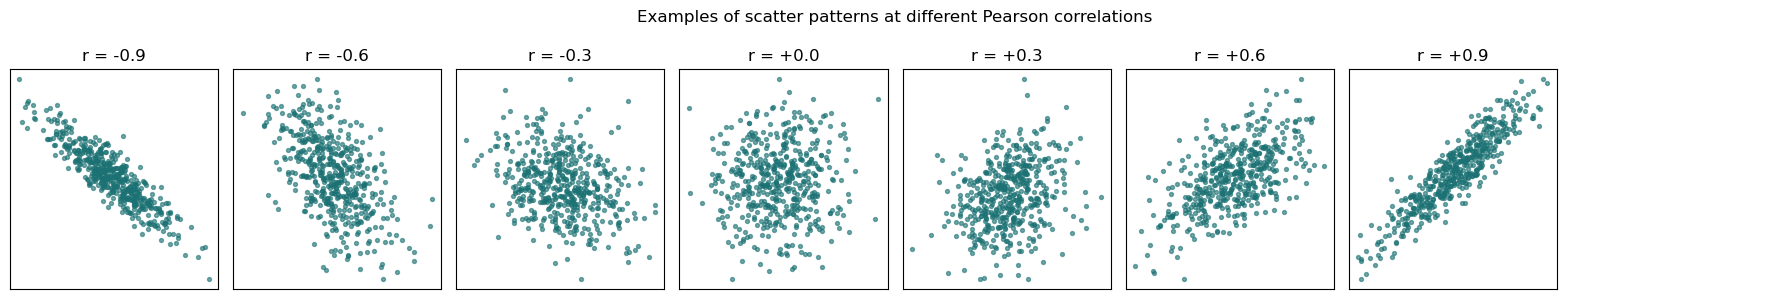

In [22]:
# Visualizing the correlations: -0.9, -0.6, -0.3, 0.0, 0.3, 0.6, 0.9
np.random.seed(42)
rs = [-0.9, -0.6, -0.3, 0.0, 0.3, 0.6, 0.9]
fig, axes = plt.subplots(1, 8, figsize=(18, 3))
axes = axes.ravel()
for i, r in enumerate(rs):
    cov = np.array([[1, r],[r, 1]])
    xy = np.random.multivariate_normal(mean=[0,0], cov=cov, size=500)
    ax = axes[i]
    ax.scatter(xy[:,0], xy[:,1], s=8, alpha=0.6, color='#1b7173')
    ax.set_title(f'r = {r:+.1f}')
    ax.set_xticks([]); ax.set_yticks([])
axes[-1].axis('off')
fig.suptitle('Examples of scatter patterns at different Pearson correlations', y=0.98)
plt.tight_layout()
plt.show()

> In the *Palmer Penguins* dataset, based on the visualizations above, we can observe the following patterns:
>
> - **Flipper length** and **body mass** show a **strong positive relationship**, indicating that heavier penguins tend to have longer flippers.  
> - **Bill length** and **bill depth** exhibit a **negative relationship**, meaning that penguins with longer bills generally have shallower ones.
>
> In the next section, we will quantify these relationships by computing correlation coefficients in Python and interpret what the resulting values tell us.

#### <font color="#fc7202">Task 2: Computing Pearson’s correlation coefficients</font>

We will use **two approaches** to calculate **Pearson’s correlation coefficients** for selected pairs of variables in the *Palmer Penguins* dataset.

First, we will use the `.corr()` method from `pandas` to compute the correlation between:
- **Flipper length** (`flipper_length_mm`) and **body mass** (`body_mass_g`)  
- **Bill length** (`bill_length_mm`) and **bill depth** (`bill_depth_mm`)  

Next, we will use the `pearsonr` function from `scipy.stats` to compute the same correlations and compare the results.


In [16]:
# Calculating Pearson correlation coefficients with pandas
r_flipper_mass = penguins['flipper_length_mm'].corr(penguins['body_mass_g'])
r_bill = penguins['bill_length_mm'].corr(penguins['bill_depth_mm'])

print('Correlation (flipper length vs body mass):', round(r_flipper_mass, 3))
print('Correlation (bill length vs bill depth):', round(r_bill, 3))

Correlation (flipper length vs body mass): 0.871
Correlation (bill length vs bill depth): -0.235


> We can also compute the **full correlation matrix**, rather than calculating correlations only between two variables, using the `.corr()` method from `pandas`.

In [17]:
# Full correlation matrix
penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']].corr()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.000000,-0.235053,0.656181,0.595110
bill_depth_mm,-0.235053,1.000000,-0.583851,-0.471916
flipper_length_mm,0.656181,-0.583851,1.000000,0.871202
body_mass_g,0.595110,-0.471916,0.871202,1.000000


> **Visualizing correlation patterns**  
>
> Besides scatter plots, **heatmaps** are also often used to visualize correlations between variables.
> They provide a compact overview of how all numeric variables relate to each other.
> As we can see below, we can directly plot the Pearson correlation coefficients for all variable pairs in the dataset, where the color indicates both the direction (positive or negative) and the strength of the relationship.

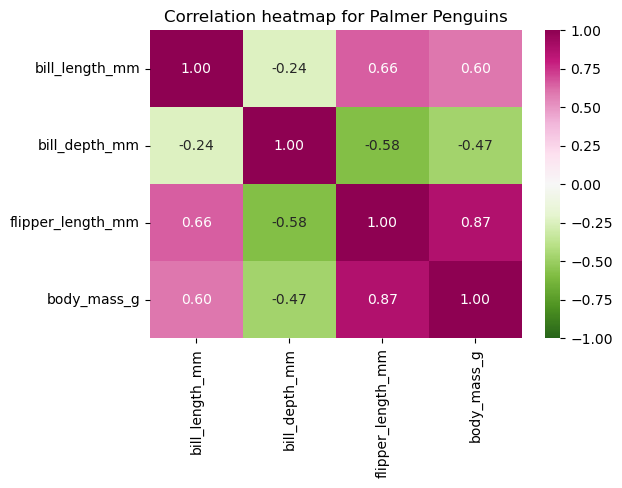

In [19]:
correlations = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlations, annot=True, cmap='PiYG_r', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation heatmap for Palmer Penguins')
plt.show()


Before we continue with the calculations using `scipy.stats`, we need to clarify one important point.

Pearson’s correlation coefficient is a **parametric measure**. This means that it is based on specific assumptions and is often used not only to **describe** relationships in a sample, but also to **test hypotheses** about relationships in the underlying population.

---

**Pearson correlation: estimation vs. hypothesis testing**

In practice, the correlation coefficient is calculated using **sample data**. In most cases, however, we are interested in whether a **linear relationship exists in the population**, not just in the observed sample.

This leads to a hypothesis test in which we assess whether the population correlation coefficient is statistically different from zero.

The hypotheses for the Pearson correlation test are:

- **Null hypothesis ($H_0$):** The correlation coefficient is not significantly different from zero, meaning there is no linear relationship in the population.  
- **Alternative hypothesis ($H_1$):** The correlation coefficient is significantly different from zero, meaning there is a linear relationship in the population.

It is therefore important to distinguish between:
- simply **calculating** the Pearson correlation coefficient, and  
- **testing** whether that correlation is statistically significant.

> **Requirements and assumptions**
>
> To **compute** Pearson’s correlation coefficient, the following conditions must be met:
> - Both variables must be **continuous**.
> - The relationship of interest is **linear**. Pearson’s correlation does not capture non-linear associations.
>
> If we want to **test** whether the Pearson correlation coefficient is significantly different from zero, additional assumptions apply:
> - Both variables should be **approximately normally distributed** in the population.

---

Compared to the `pandas` implementation, which only returns the correlation coefficient, the `scipy.stats` implementation provides both:
- the **Pearson correlation coefficient**, and  
- the associated ***p*-value**.

The *p*-value allows us to formally test the hypotheses above and decide, by comparing it with a chosen significance level ($\alpha$), whether the observed correlation is statistically significant.



In [31]:
# Calculating Pearson correlation coefficients with scipy.stats

# Drop rows with missing values for each variable pair
flipper_mass = penguins[['flipper_length_mm', 'body_mass_g']].dropna()
bill_dims = penguins[['bill_length_mm', 'bill_depth_mm']].dropna()

# Pearson correlations
r_flipper_mass_scipy, p_flipper_mass_scipy = pearsonr(flipper_mass['flipper_length_mm'], flipper_mass['body_mass_g'])
r_bill_scipy, p_bill_scipy = pearsonr(bill_dims['bill_length_mm'], bill_dims['bill_depth_mm'])

print(f"Correlation (flipper length vs body mass): r = {r_flipper_mass_scipy:.3f}, p = {p_flipper_mass_scipy:.4f}")
print(f"Correlation (bill length vs bill depth): r = {r_bill_scipy:.3f}, p = {p_bill_scipy:.4f}")

Correlation (flipper length vs body mass): r = 0.871, p = 0.0000
Correlation (bill length vs bill depth): r = -0.235, p = 0.0000


As we can see, the correlation coefficients $r$ are the same regardless of the implementation used, whether computed with `pandas` or with `scipy.stats`. This confirms that both approaches estimate the same Pearson correlation coefficient.

Based on the *p*-values, we can formally assess statistical significance. In both cases, the *p*-values are **very small** and well below a typical significance level of $\alpha = 0.05$. We therefore reject the null hypothesis of no linear relationship.

For **flipper length** and **body mass**, the correlation is **strong and positive** ($r = 0.871$), indicating that heavier penguins tend to have substantially longer flippers.  
For **bill length** and **bill depth**, the correlation is **negative and weak** ($r = -0.235$), suggesting that penguins with longer bills tend to have slightly shallower bills.

These conclusions are consistent with our earlier visual inspection of the scatter plots. Even before calculating any numerical measures, we were already able to reason about the **direction** and **strength** of the relationships.

How was this possible?

Most likely, you were implicitly trying to draw a straight line through the cloud of points in your mind. In other words, you were already performing **linear regression** intuitively.


## Linear regression

> Before we continue, let us briefly recall some high school mathematics.  
> The equation of a straight line is:
> $$
> y = ax + b
> $$
> Here, $x$ and $y$ are two variables, $a$ is the **slope**, and $b$ is the **intercept**.  
> The intercept $b$ represents the value of $y$ when $x = 0$.  
> The slope $a$ describes how much $y$ changes when $x$ increases by one unit.  
> If $a > 0$, the line increases as $x$ increases.  
> If $a < 0$, the line decreases as $x$ increases.

Now that this looks familiar again, it should not be surprising that a **regression line** is described by a very similar equation. The key difference is that we now apply it to data:

$$
\hat{y}_i = \beta_1 x_i + \beta_0
$$

Here, $x_i$ is the value of the **predictor variable** (independent variable) for observation $i$, and $\hat{y}_i$ is the **predicted value** of the **outcome variable** (dependent variable).

> We use a hat on $y$ to emphasize that these values are *predictions*, not observed data points.  
> The coefficients use different symbols by convention in statistics: $\beta_0$ denotes the intercept, and $\beta_1$ denotes the slope.

Of course, when working with real data, the observed points never lie perfectly on the regression line. The difference between an observed value $y_i$ and its predicted value $\hat{y}_i$ is called a **residual**:

$$
e_i = y_i - \hat{y}_i
$$

Putting everything together, we can write the complete linear regression model as:

$$
y_i = \beta_1 x_i + \beta_0 + e_i
$$

> The residual term $e_i$ captures the part of $y_i$ that cannot be explained by the linear relationship. It represents random variation or noise around the regression line.

Now let us redraw our scatter plot of the *Palmer Penguins* data, with **flipper length** on the *x*-axis and **body mass** on the *y*-axis. This time, we will also add the **regression line** defined above.

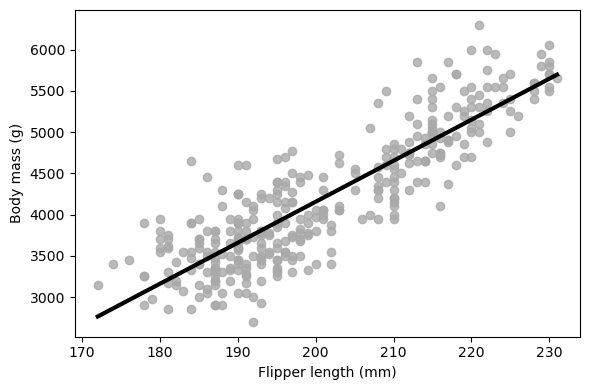

In [48]:
# Drop rows with missing values for flipper length and body mass
penguins = penguins.dropna(subset=['flipper_length_mm', 'body_mass_g'])

# Creating the scatterplot with regression line
plt.figure(figsize=(6, 4))

sns.regplot(data=penguins, x='flipper_length_mm', y='body_mass_g', color='darkgray',
            ci=None,          # no confidence interval shading
            line_kws={'color': 'black', 'lw': 3}  # regression line style
)

plt.xlabel('Flipper length (mm)')
plt.ylabel('Body mass (g)')
plt.tight_layout()
plt.show()

You will notice that the regression line runs roughly through the middle of the data points, capturing the general upward trend: penguins with longer flippers tend to have higher body mass.

To assess how well this line fits the data, we can also examine the **residuals** for each observation. These are simply the vertical distances between the observed data points and the regression line.  
When the line fits the data well, the residuals are relatively small; when the fit is poor, the residuals are larger.  

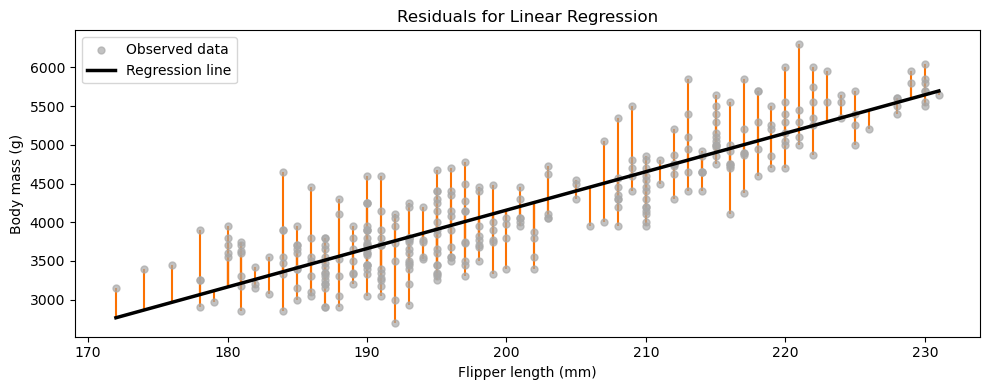

In [49]:
# Preparing data for regression
x = penguins['flipper_length_mm'].to_numpy()
y = penguins['body_mass_g'].to_numpy()

# Fitting a simple linear regression model (Ordinary Least Squares, OLS)
X = sm.add_constant(x)                      # add intercept term
model = sm.OLS(y, X).fit()
y_hat = model.predict(X)                    # predicted (fitted) values

# Sorting values by x for a smooth regression line
order = np.argsort(x)
x_sorted = x[order]
y_hat_sorted = y_hat[order]

# Creating the scatterplot with regression line and residuals
plt.figure(figsize=(10, 4))
plt.scatter(x, y, color='darkgray', s=25, label='Observed data', alpha=0.7)
plt.plot(x_sorted, y_hat_sorted, color='black', linewidth=2.5, label='Regression line')

# Drawing residuals as vertical lines
plt.vlines(x, y_hat, y, color='#fc7202', linewidth=1.5, zorder=0)

plt.xlabel('Flipper length (mm)')
plt.ylabel('Body mass (g)')
plt.title('Residuals for Linear Regression')
plt.legend()
plt.tight_layout()
plt.show()


In a well-fitting model, the small orange segments representing the residuals are short and fairly evenly distributed above and below the regression line. This indicates that the model captures the overall pattern in the data reasonably well.

In contrast, when a model fits poorly, the residuals tend to be much larger and may exhibit a visible pattern, suggesting that the regression line systematically fails to describe certain parts of the data.

We can further assess model adequacy by plotting the **residuals against the fitted (predicted) values**, a procedure commonly referred to as **residual analysis**.  
If the regression model is appropriate, the residuals should be randomly scattered around zero, without any clear trend or structure.


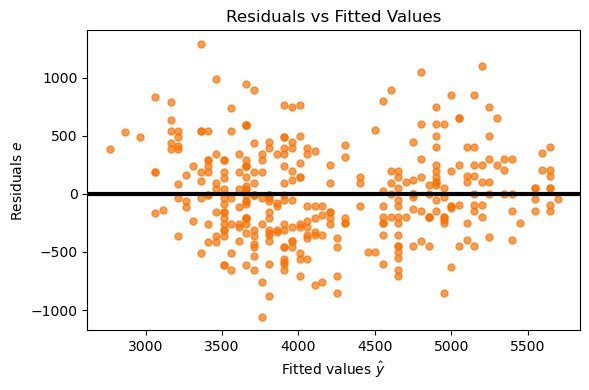

In [50]:
# Computing residuals (difference between observed and predicted values)
residuals = y - y_hat

# Creating the residuals vs fitted plot
plt.figure(figsize=(6, 4))
plt.scatter(y_hat, residuals, s=25, color='#fc7202', alpha=0.7)
plt.axhline(0, color='black', linewidth=3)       # horizontal line at zero

plt.xlabel('Fitted values $\hat{y}$')
plt.ylabel('Residuals $e$')
plt.title('Residuals vs Fitted Values')
plt.tight_layout()
plt.show()

> Beyond this visual check, a key assumption of linear regression is that the **residuals are approximately normally distributed**.
>
> This assumption is motivated by the idea that, once the systematic relationship between the variables has been modeled, the remaining variation consists of many small and independent sources of random error. Under these conditions, the **Central Limit Theorem** implies that the residuals will be approximately normally distributed.
>
> Normally distributed residuals are important because they ensure the validity of many inferential procedures in linear regression, such as *t*-tests for individual coefficients, *F*-tests for overall model significance, and the construction of reliable confidence intervals.
>
> As a result, residual analysis commonly also includes checking the normality of residuals. This can be done using formal statistical tests, such as the **Kolmogorov–Smirnov** test or the **Shapiro–Wilk** test, as well as graphical tools like **Q–Q plots**.
>
> In the next figure, some of the **most common** residual patterns encountered in practice are summarized.
>
> The first plot shows the **ideal situation**: the residuals have constant variance and are independent, meaning they are randomly scattered around zero with no visible structure.  
This is what we expect when the model is well specified and the assumptions of linear regression are met.
>
> The second plot illustrates a case where the variance of the residuals changes with the fitted values, a problem known as **heteroscedasticity**.  
Here, the spread of the residuals increases as the fitted values increase, violating the assumption of constant variance.
>
> The remaining plots show examples in which residuals exhibit clear patterns, indicating a **lack of independence** or that the **model fails to capture important aspects** of the underlying relationship.
>
> Recognizing these patterns is crucial. They help diagnose which regression assumptions are violated and guide decisions on how the model can be improved.


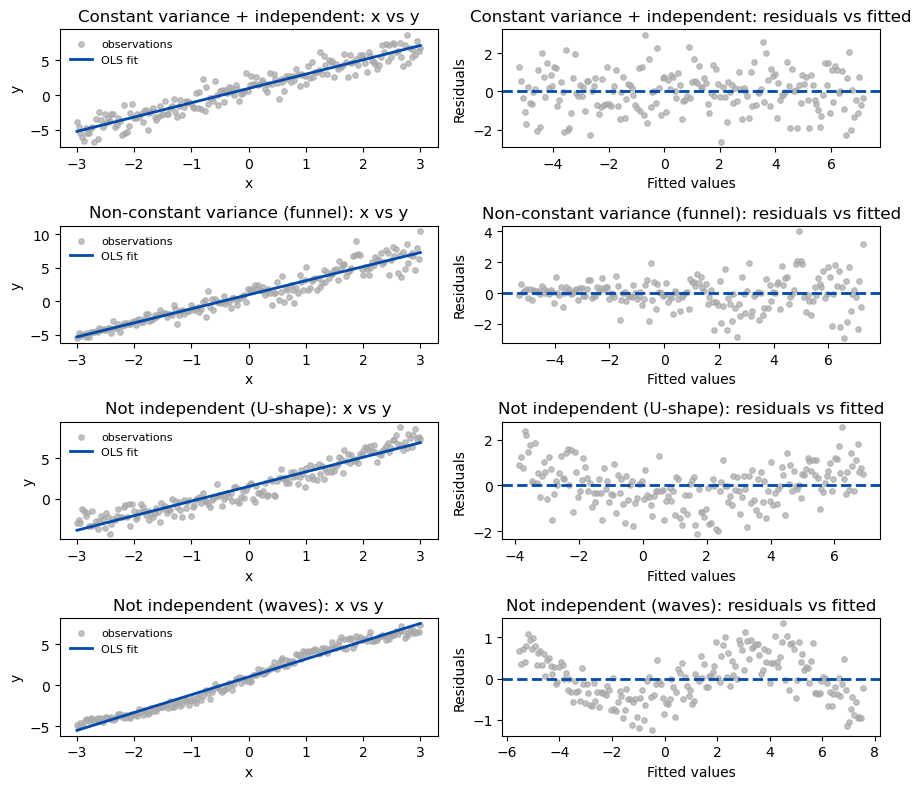

In [60]:
rng = np.random.default_rng(17)

# Generating a shared predictor
n = 200
x = np.linspace(-3, 3, n)

def fit_slr(xv, yv):
    # Fitting a simple linear regression using OLS
    X = sm.add_constant(xv)
    model = sm.OLS(yv, X).fit()
    yhat = model.predict(X)
    resid = yv - yhat
    return yhat, resid

# Well-specified linear model
eps1 = rng.normal(0, 1.0, n)
y1 = 1.0 + 2.0 * x + eps1
yhat1, r1 = fit_slr(x, y1)

# Non-constant variance increasing with x (one-sided funneling)
scale2 = 0.4 + 1.0 * ((x - x.min()) / (x.max() - x.min()))
eps2 = rng.normal(0, 1.0, n) * scale2
y2 = 1.0 + 2.0 * x + eps2
yhat2, r2 = fit_slr(x, y2)

# Nonlinearity (residuals are not independent) (subtle U-shape)
eps4 = rng.normal(0, 0.8, n)
y4 = 1.0 + 1.8 * x + 0.18 * (x ** 2) + eps4
yhat4, r4 = fit_slr(x, y4)

# Nonlinearity (residuals are not independent) (subtle wave-shaped pattern)
eps5 = 0.8 * np.sin(1.2 * x) + rng.normal(0, 0.35, n)
y5 = 1.0 + 2.0 * x + eps5
yhat5, r5 = fit_slr(x, y5)

fig, axes = plt.subplots(4, 2, figsize=(9, 8))

cases = [
    (x, y1, yhat1, r1, 'Constant variance + independent'),
    (x, y2, yhat2, r2, 'Non-constant variance (funnel)'),
    (x, y4, yhat4, r4, 'Not independent (U-shape)'),
    (x, y5, yhat5, r5, 'Not independent (waves)'),
]

for row, (xv, yv, yhat, rv, title) in enumerate(cases):
    # Plotting x vs y with OLS fit
    ax_xy = axes[row, 0]
    ax_xy.scatter(xv, yv, s=15, alpha=0.7, color='darkgray', label='observations')
    ax_xy.plot(xv, yhat, lw=2, label='OLS fit', color='#004aad')
    ax_xy.set_title(f'{title}: x vs y')
    ax_xy.set_xlabel('x')
    ax_xy.set_ylabel('y')
    ax_xy.legend(frameon=False, fontsize=8)

    # Plotting residuals vs fitted
    ax_res = axes[row, 1]
    ax_res.scatter(yhat, rv, s=15, alpha=0.7, color='darkgray')
    ax_res.axhline(0, ls='--', lw=2, color='#004aad')
    ax_res.set_title(f'{title}: residuals vs fitted')
    ax_res.set_xlabel('Fitted values')
    ax_res.set_ylabel('Residuals')

plt.tight_layout()
plt.show()

This all gives us an intuitive idea of what we want from regression: **a line that makes the residuals as small as possible**.  
Mathematically, this means we are looking for the values of the coefficients $\beta_0$ and $\beta_1$ that minimize the total squared distance between the observed and predicted values, known as the **sum of squared residuals**:

$$
\text{minimize} \; \sum_{i=1}^{n} e_i^2
$$

or, written more explicitly,

$$
\text{minimize} \; \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

The specific coefficient values that achieve this minimum are called **estimates**, denoted by $\hat{\beta}_0$ and $\hat{\beta}_1$, to indicate that they are our best guesses of the true, but unknown, population parameters.

This approach to estimating regression coefficients is known as **Ordinary Least Squares (OLS)** regression.

---

Now let us put this into practice.  
We will fit an OLS regression model for the *Palmer Penguins* dataset, using **flipper length** as the predictor variable and **body mass** as the response variable. We will then examine the model summary to see what information it provides.


#### <font color="#fc7202">Task 3: Simple linear regression</font>

In this task, we will use the `statsmodels` library to fit a simple linear regression model.

In [52]:
# Fitting OLS model: body mass as a function of flipper length
model1 = smf.ols('body_mass_g ~ flipper_length_mm', data=penguins).fit()

# Model summary
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     1071.
Date:                Wed, 21 Jan 2026   Prob (F-statistic):          4.37e-107
Time:                        00:00:20   Log-Likelihood:                -2528.4
No. Observations:                 342   AIC:                             5061.
Df Residuals:                     340   BIC:                             5069.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -5780.8314    305.81

After running the code, the OLS summary provides a large amount of information at a glance. It reports the `Dep. Variable` (the outcome being modeled), the `Method` used (OLS), the `No. Observations`, as well as the `Date` and `Time` when the model was fit. We will return to several of these fields later and discuss them in more detail.

For now, focus on the central part of the table, in particular the `coef` values for the `Intercept` and for `flipper_length_mm`. These are the estimated regression coefficients:
- **Intercept:** $-5780.8314$  
- **Slope for flipper length:** $49.6856$

Using these estimates, we can write the fitted regression equation as:

$$
\hat{y} = 49.6856 \cdot \text{flipper\_length\_mm} - 5780.8314
$$

> *Interpretation:* For each additional millimeter of flipper length, the predicted body mass increases by approximately $49.69$ grams on average.  
> The intercept represents the predicted body mass when flipper length is zero. Since this value lies far outside the observed data range, it has no direct biological interpretation here and primarily serves as a mathematical anchor for the regression line.


> *Note:* We can also access these model outputs directly in Python, without printing the full summary.  
> For example, if we want to extract the estimated coefficients, we can do so programmatically:


In [53]:
# Accessing estimated coefficients
model1.params

Intercept           -5780.831358
flipper_length_mm      49.685566
dtype: float64

> This returns both the intercept and the slope estimates.
>
> Similarly, if you want to extract only one of them, you can access it directly by name:

In [54]:
# Intercept
print(model1.params['Intercept'])

# Slope
print(model1.params['flipper_length_mm'])

-5780.831358077063
49.68556640610008


> If you are interested only in the fitted (predicted) values or the residuals, you can access them as follows:

In [55]:
# Predicted values and residuals
print(f'Predicted values: {model1.fittedvalues}')
print(f'Residuals: {model1.resid}')

Predicted values: 0      3212.256161
1      3460.683993
2      3907.854091
4      3808.482958
5      3659.426259
          ...     
338    4851.879853
340    4901.565419
341    5249.364384
342    4752.508720
343    4802.194286
Length: 342, dtype: float64
Residuals: 0      537.743839
1      339.316007
2     -657.854091
4     -358.482958
5       -9.426259
          ...    
338     73.120147
340    -51.565419
341    500.635616
342    447.491280
343    597.805714
Length: 342, dtype: float64


> These attributes are particularly useful when you want to visualize or further analyze the model results, for example to plot residuals as part of a residual analysis or to compare predicted and observed values.

#### Coefficient of determination ($R^2$)

Let us now turn to another key quantity reported in the model summary: **`R-squared`**.

So far, we have used the **correlation coefficient ($r$)** to describe the *direction* and *strength* of a linear relationship between two variables. The **coefficient of determination**, $R^2$, looks at the same relationship from a complementary perspective. It quantifies **how well the regression model explains the observed data**, expressed as the **proportion of the total variability in the outcome variable** that can be attributed to the predictor(s) included in the model.

**Decomposing variability**

For a simple linear regression model $\hat{y}_i = \beta_1 x_i + \beta_0,$ the total variability in the outcome variable $y$ can be decomposed into two components:

- **Explained (model) variation:** variability captured by the regression line  
- **Unexplained (residual) variation:** variability remaining around the line  

This decomposition is expressed using **sums of squares**: $SS_{\text{total}} = SS_{\text{regression}} + SS_{\text{residual}},$ where:
- $SS_{\text{total}} = \sum_i (y_i - \bar{y})^2$  
- $SS_{\text{regression}} = \sum_i (\hat{y}_i - \bar{y})^2$  
- $SS_{\text{residual}} = \sum_i (y_i - \hat{y}_i)^2$  

**Definition of $R^2$**

The coefficient of determination is defined as the **fraction of total variability explained by the model**:

$$
R^2 = \frac{SS_{\text{regression}}}{SS_{\text{total}}}
$$

Using the decomposition above, this can also be written as:

$$
R^2 = 1 - \frac{SS_{\text{residual}}}{SS_{\text{total}}}
$$

This formulation makes the interpretation clear:  
**smaller residual variation leads to a larger $R^2$ and a better-fitting model**.

By definition, $R^2$ always lies between **0** and **1**:
- **$R^2 = 1$** corresponds to a perfect fit, where the model explains all variability in the outcome.  
- **$R^2 = 0$** corresponds to a model that explains none of the variability and performs no better than simply predicting the mean.

> For our simple regression model predicting **body mass from flipper length**, we obtain **$R^2 = 0.759$**.  
> This means that approximately **75.9% of the variation in body mass** is explained by differences in **flipper length**.  
> The remaining **24.1%** reflects unexplained variability due to individual differences, measurement noise, or other biological factors not included in the model.

**Connection to correlation in simple regression**

In simple linear regression with a single predictor, $R^2$ is directly related to the Pearson correlation coefficient: $R^2 = r_{xy}^2$

That is, $R^2$ is simply the square of the correlation between the predictor and the outcome.  
You can verify this relationship directly using the values computed earlier (`r_flipper_mass_scipy`).


In [64]:
print(f'Correlation (r): {r_flipper_mass_scipy:.4f},  R² = {r_flipper_mass_scipy**2:.4f}')

Correlation (r): 0.8712,  R² = 0.7590


#### Hypothesis tests for regression models

The regression **model summary** does not only report estimated coefficients and goodness-of-fit measures. It also contains the results of **formal hypothesis tests** that allow us to assess whether the fitted model, and its individual predictors, are **statistically significant**.

In linear regression, there are two main types of hypothesis tests reported in the summary:

1. **Testing the model as a whole**  
   Does the regression model explain a statistically significant amount of variation in the outcome compared to a model that includes only an intercept?

   - **Null hypothesis ($H_0$):** All slope coefficients are equal to zero, meaning the predictors do not explain variation in the outcome.  
   - **Alternative hypothesis ($H_1$):** At least one slope coefficient differs from zero.

   This question is addressed using the ***F*-test**, which compares how much variability is explained by the model to how much variability remains unexplained.  
   The result of this test is summarized in the model output by the ***F*-statistic** and its associated *p*-value.

2. **Testing individual coefficients**  
   Even if the overall model is significant, we may still want to know **which predictors** are actually contributing to the relationship.

   To evaluate each predictor individually, we use a ***t*-test** for each regression coefficient.

   For each predictor $x_j$, the hypotheses are:

   - **Null hypothesis ($H_0$):** $\beta_j = 0$ → the predictor has no effect on the outcome.  
   - **Alternative hypothesis ($H_1$):** $\beta_j \neq 0$ → the predictor has a statistically significant effect on the outcome.

> For our simple regression model predicting **body mass from flipper length**, the overall *F*-test yields an **F-statistic of 1071** with a **very small *p*-value** ($p = 4.37 \times 10^{-107}$).  
> Since this *p*-value is far below a typical significance level of $\alpha = 0.05$, we reject the null hypothesis and conclude that the regression model as a whole explains a **statistically significant amount of variation** in body mass.
>
> Examining the individual coefficients, the slope for **flipper length** is estimated as **49.69** with a **very small *p*-value**.  
> Because this *p*-value is also well below $\alpha = 0.05$, we reject the null hypothesis $\beta_1 = 0$ and conclude that flipper length is a **statistically significant predictor** of body mass.
>
> In practical terms, this means that the positive relationship observed between flipper length and body mass is unlikely to be due to random chance and reflects a genuine linear association in the population.



### Multiple Linear Regression

So far, we have worked only with **simple linear regression**, where a single predictor is used to explain variation in one outcome variable, for example predicting *body mass* from *flipper length* in the penguins dataset.

In environmental science, however, many processes depend on **multiple variables simultaneously**.  
For instance, if we want to **predict chronic zinc toxicity** in the freshwater microalga *Chlorella* sp., it would not be sufficient to consider only one factor.  
Zinc toxicity is influenced by several **toxicity-modifying factors**, such as **pH**, **water hardness**, and **dissolved organic carbon (DOC)**. These factors may also interact with one another.

To account for such situations, we use **multiple linear regression (MLR)**, which allows us to include several predictors in a single model.  
A multiple regression model with three predictors can be written as:

$$
y_i = \beta_1 x_{1i} + \beta_2 x_{2i} + \beta_3 x_{3i} + \beta_0 + e_i
$$

where:
- $y_i$ is the measured zinc toxicity for sample $i$,  
- $x_{1i}$ is pH,  
- $x_{2i}$ is hardness,  
- $x_{3i}$ is dissolved organic carbon (DOC), and  
- $e_i$ is the residual, representing unexplained variation.

Each coefficient ($\beta_1$, $\beta_2$, $\beta_3$) represents the expected change in toxicity associated with a one-unit increase in the corresponding predictor, **holding all other variables constant**.  
The intercept $\beta_0$ represents the baseline value of the outcome when all predictors are equal to zero.

As in simple linear regression, the coefficients are estimated by minimizing the **sum of squared residuals**:

$$
\text{minimize} \; \sum_{i=1}^{n} e_i^2
$$

The equation above illustrates a multiple regression model with **three predictors**.  
If additional predictors are included, the structure of the model remains the same: each new variable is added with its own coefficient.

In general, for a model with $k$ predictor variables, the multiple linear regression equation can be written as:

$$
y_i = \beta_1 x_{1i} + \beta_2 x_{2i} + \dots + \beta_k x_{ki} + \beta_0 + e_i
$$

Here, each $\beta_j$ (for $j = 1, 2, \dots, k$) represents the regression coefficient associated with the $j$-th predictor variable.


> After seeing that, in some cases, adding more predictors can improve a model’s predictive performance, a natural question arises:  
**can we also improve our simple penguin body mass–flipper length model by including additional variables?**
>
> For example, instead of using only **flipper length**, we might also consider **bill length** as an additional predictor.  
> In the next task, we will explore whether adding this extra variable improves the model.

#### <font color="#fc7202">Task 4: Extending the model with an additional predictor</font>

In the following code, we fit a multiple linear regression model using **flipper length** and **bill length** as predictors of **body mass**.



In [65]:
# MLR with flipper_length_mm + bill_length_mm
model2 = smf.ols('body_mass_g ~ flipper_length_mm + bill_length_mm', data=penguins).fit()
print(model2.summary())

# Coefficients and equation
b0 = model2.params['Intercept']
b_flipper = model2.params['flipper_length_mm']
b_billlen = model2.params['bill_length_mm']
print(f'Equation: ŷ = {b_flipper:.4f} · flipper_length_mm + {b_billlen:.4f} · bill_length_mm + ({b0:.4f})')

                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     536.6
Date:                Wed, 21 Jan 2026   Prob (F-statistic):          9.09e-106
Time:                        01:34:13   Log-Likelihood:                -2527.7
No. Observations:                 342   AIC:                             5061.
Df Residuals:                     339   BIC:                             5073.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -5736.8972    307.95

> When we extend the simple regression model by adding **bill length** as a second predictor, we observe only a **very small change in model performance**.
>
> The coefficient of determination increases from **$R^2 = 0.759$** in the simple model to **$R^2 = 0.760$** in the multiple regression model. This indicates that adding bill length explains **only an additional 0.1% of the variation** in body mass, which is a negligible improvement.
>
> Looking at the individual coefficients, **flipper length** remains a **strong and statistically significant predictor** of body mass (*p* < $\alpha = 0.05$).  
> In contrast, the coefficient for **bill length** is **not statistically significant** (*p* = 0.244 > $\alpha = 0.05$), meaning that once flipper length is accounted for, bill length does not provide meaningful additional explanatory power.
>
> This example highlights an important lesson in multiple linear regression: **adding more predictors does not automatically lead to better models**.  
> A new variable only improves the model if it contributes independent information beyond what is already captured by existing predictors.
>
> In this case, flipper length alone already explains most of the variation in body mass, and adding bill length does not substantially improve the model.


#### <font color="#fc7202">Let’s play: Guess the correlation!</font>

- **Game 1:** Guess The Correlation → <https://www.guessthecorrelation.com/>
- **Game 2:** GeoGebra “Guess r” → <https://www.geogebra.org/m/KE6JfuF9>